In [139]:
from shapely import *
import shapely.plotting as splt
import shapely.ops as sopt
import shapely as shp

import matplotlib.pyplot as plt
import numpy as np

import sympy as smp

from icecream import ic

## geometry

In [17]:
# split room into points, create cells around each points, and determine the adjacency of these cells 

# create a room 
# create offset curve to describe surroundings, and make it into a polygon 
# use numpy to make a mesh of points that are evenly distributed 
# use buffer to create cells based on these points and the overlap/ intersection with the polygons 
# give cells properties based on their relation to the room/surroundings...
# use str tree thing to identify neighbours of each cell 

In [18]:
# create a room 
room_lx = 20 #m - length in x
room_ly= 10 #m 
room_poly = box(0.0, 0.0, room_lx, room_ly)

In [19]:
# use buffer to describe ambient 
amb_poly = room_poly.buffer(1, cap_style="square", join_style="mitre")
amb_poly_diff = amb_poly.difference(room_poly)

In [20]:
# use numpy to make a mesh of points that are evenly distributed 
room_xy = room_poly.exterior.coords.xy

num_points = 5
x = np.linspace(np.min(room_xy[0]), np.max(room_xy[0]), num_points)
y = np.linspace(np.min(room_xy[1]), np.max(room_xy[1]), num_points)
xv, yv = np.meshgrid(x,y)

room_pts = [(x,y) for x,y in zip(xv.flatten(), yv.flatten())]

In [21]:
def box_from_centroid(centroid, dx, dy):
    # centroid should be a tuple
    # create a box based on a centroid with coordinates going in ccw direction (starting from top-left => v1, v2, v3, v4 <= top right)
    cx, cy = centroid

    v1x = v2x = cx - dx/2
    v4x = v3x = cx + dx/2

    v1y = v4y = cy - dy/2
    v2y = v3y = cy + dy/2

    coords = (
        (v1x, v1y),
        (v2x, v2y),
        (v3x, v3y),
        (v4x, v4y)
    )

    # return coords

    return Polygon(coords)


In [24]:
# create cells around points in mesh of points 
dx = room_lx/(num_points - 1)
dy = room_ly/(num_points - 1)
cells = [box_from_centroid(pt, dx, dy) for pt in room_pts]

#all cells should have the same area 
assert len(np.unique(np.array([cell.area for cell in cells]))) == 1


In [25]:
# edit cell geometries based on overlap with room geom 
cells_trimmed = {}
for ix, cell in enumerate(cells):
    if not cell.within(room_poly):
        cells_trimmed[ix] = cell.intersection(room_poly)
    else:
        cells_trimmed[ix] = cell


In [26]:
# find the neighbours of each cell - those that have overlapping boundaries (not just points)
tree = STRtree(list(cells_trimmed.values()))


cells_nb = {} # nb - neighbours
nb_pattern = 'FF2F11212' # used relate function to id DE-9IM pattern

for k,v in cells_trimmed.items(): 
    cells_nb[k] = []
    near_cells_ix = tree.query(v).tolist() 

    for ix in near_cells_ix:
        if v.relate_pattern(cells_trimmed[ix], nb_pattern):
            cells_nb[k].append(ix)


    

In [128]:
cells_nb[0]

In [138]:
cell_num = 0

vs = list(cells_trimmed[cell_num].exterior.coords)
lines = {}
for ix, _ in enumerate(vs):
    if ix < len(vs) - 1:
        lines[ix] = LineString((vs[ix], vs[ix+1]))

line_nb_touch_pattern = "F1FF0F212"
for l_num, l in lines.items():
    for ixn in cells_nb[cell_num]:
        print(l_num, ixn, l.relate_pattern(cells_trimmed[ixn], line_nb_touch_pattern ))


0 1 True
0 5 False
1 1 False
1 5 False
2 1 False
2 5 False
3 1 False
3 5 True


In [ ]:
# 0->1 0 1 F1FF0F212
# 3->5 3 5 F1FF0F212

In [130]:
lines

{0: <LINESTRING (2.5 1.25, 2.5 0)>,
 1: <LINESTRING (2.5 0, 0 0)>,
 2: <LINESTRING (0 0, 0 1.25)>,
 3: <LINESTRING (0 1.25, 2.5 1.25)>}

## calculus

In [146]:
cells_temp = {ix: k for ix, k in enumerate(smp.symbols(f"T0:{len(cells_trimmed.values())}"))}

In [64]:
def get_flow_direction(line):
    t = line.xy
    dy = t[1][1] - t[1][0] # y dir if rise != 0
    dx = t[0][1] - t[0][0] # x 

    if dy==0:
        dir="x"
    else:
        dir="y"

    return dir

def get_rel_length(line, typical_length):
    return line.length/typical_length

In [156]:
amb_touch_pattern = 'F1FF0F212'
line_nb_touch_pattern = "F1FF0F212"

def boundary_cell_eq(cell_num=0, cells_polygon=cells_trimmed, cells_nb=cells_nb, cells_temp=cells_temp, gen_dx=dx, gen_dy=dy):
    Tamb, h, k, delta_x, delta_y = smp.symbols("T_ininity, h, k,delta_x, delta_y")
    Tself = cells_temp[cell_num]

    # specific cell and its vertices 
    cell = cells_polygon[cell_num]
    vs = list(cell.exterior.coords)

    # create lines based on vertices 
    lines = {}
    for ix, _ in enumerate(vs):
        if ix < len(vs) - 1:
            lines[ix] = LineString((vs[ix], vs[ix+1]))
    # TODO somehow check that this is valid 

    terms = []
    for line_num,L in lines.items():
        dirxy = get_flow_direction(L)
        ic(dirxy)
        rel_len = get_rel_length(L, gen_dx) if dirxy == "x" else get_rel_length(L, gen_dy)

        # convection 
        if L.relate_pattern(amb_poly_diff, amb_touch_pattern):
            term =  h * (Tamb - Tself)  * rel_len
            if dirxy == "x": 
                term = term * delta_x
            else:
                term = term * delta_y
            
            terms.append(term)
        
        # conduction 
        else:
            dxdy = delta_x/delta_y if dirxy == "x" else delta_y/delta_x
            # have to cycle though all neigbours..
            for ixn in cells_nb[cell_num]: 
                if L.relate_pattern(cells_polygon[ixn], line_nb_touch_pattern):
                    ic(line_num, ixn) # this should only occur once per line number # TODO enforce a check here 
                    Tnb = cells_temp[ixn]

                    term = k * rel_len * dxdy * (Tnb - Tself)

                    terms.append(term)

                    


    return terms
    

ic| line_num: 0, ixn: 1


ic| line_num: 3, ixn: 5


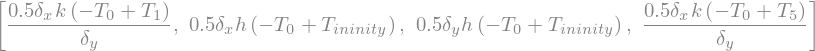

In [152]:
boundary_cell_eq(cell_num=0)


ic| dirxy: 'x'
ic| line_num: 0, ixn: 6
ic| dirxy: 'y'
ic| line_num: 1, ixn: 2
ic| dirxy: 'x'
ic| dirxy: 'y'
ic| line_num: 3, ixn: 0


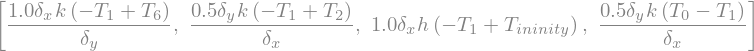

In [157]:
boundary_cell_eq(cell_num=1)

ic| dirxy: 'y'
ic| line_num: 0, ixn: 5
ic| dirxy: 'x'
ic| line_num: 1, ixn: 11
ic| dirxy: 'y'
ic| line_num: 2, ixn: 7
ic| dirxy: 'x'
ic| line_num: 3, ixn: 1


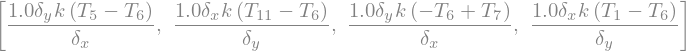

In [158]:
boundary_cell_eq(cell_num=6)

In [97]:
boundary_cell_eq(cells_trimmed[1])

[1.0*dx*h*(T_ininity - 1)]

### old procedure

In [222]:
def make_conduction_term(T1, T2, dir="x", corner=False):
    k, dx, dy = symbols("k, dx, dy")

    term = k * (T2 - T1) 

    if dir == "x":
        term = term * (dy/dx)
    else:
        term = term * (dx/dy)

    if corner:
        term = term/2

    return term

def make_convection_term(T1, corner=False, edge=False, dir="x"):
    Tamb, h, dx, dy = symbols("T_ininity, h, dx, dy")
    
    term =  h * (Tamb - T1) 

    if edge:
        if dir == "x": #TODO could be both 
            term = term * dx
        elif term == "y":
            term = term * dy
        elif term == "dxdy":
            term = term * dy * dx 

    if edge:
        term = term/2

    if corner:
        term = term/4

    return term

def make_heat_generation_term(corner=False, edge=False):
    e, dx, dy = symbols("e, dx, dy")
    term = dy*dx*e

    if edge:
        term = term/2

    if corner:
        term = term/4

    return term
    
    

In [223]:
make_heat_generation_term()

dx*dy*e

In [217]:
T1, T2 = symbols("T1, T2")

make_conduction_term(T1, T2, dir="y", )

dx*k*(-T1 + T2)/dy

## visuals

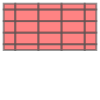

In [144]:
MultiPolygon(cells_trimmed)

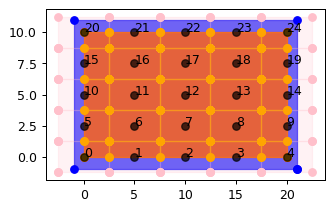

In [163]:
GM = (np.sqrt(5)-1.0)/2.0
W = 4
H = W*GM
SIZE = (W, H)

fig = plt.figure(figsize=SIZE,  dpi=90)
ax = fig.add_subplot(111)


splt.plot_polygon(amb_poly, ax=ax, alpha=0.7, color="blue")
splt.plot_polygon(room_poly, ax=ax, alpha=0.7, color="red")



for cell in cells:
    splt.plot_polygon(cell, ax=ax, alpha=0.2, color="pink")

for (name, cell), pt in zip(cells_trimmed.items(),room_pts):
    splt.plot_polygon(cell, ax=ax, alpha=0.4, color="orange")
    ax.annotate(name, pt)


splt.plot_points(MultiPoint(room_pts), ax=ax, alpha=0.7, color="black")